In [1]:
from nudging.simulation import generate_datasets
from nudging.cate import get_cate, get_cate_correlations
from nudging.model import BiRegressor
from nudging.model import ProbModel, MDMModel, PCAModel
from sklearn.linear_model import ARDRegression, LogisticRegression
import numpy as np
from matplotlib import pyplot as plt
from nudging.cluster import KSplitPartitioner, compute_partition_correlation, KMeansPartitioner, RandomPartitioner
from scipy.stats import spearmanr
from collections import defaultdict

In [2]:
np.random.seed(1298734)
sim_datasets = generate_datasets(500)

In [3]:
models = {
    "mdm": MDMModel(ARDRegression()),
    "prob_log": ProbModel(LogisticRegression()),
    "prob_bay": ProbModel(ARDRegression()),
    "t-learner": BiRegressor(ARDRegression()),
    "pca": PCAModel(ARDRegression()),
}

In [10]:
def plot_sub_cates(datasets):
    for model_name, model in models.items():
        all_sub = defaultdict(lambda: [])

        for dataset in datasets:
            res = compute_partition_correlation(model, dataset, KSplitPartitioner, KMeansPartitioner)
            for name in res:
                all_sub[name].append(res[name])

        plt.scatter(all_sub["all"], all_sub["individual"], label=model_name)
        print(model_name, spearmanr(all_sub["all"], all_sub["individual"]))
    plt.legend()
    plt.show()

mdm SpearmanrResult(correlation=0.7287780831123324, pvalue=6.091045587222503e-84)
prob_log SpearmanrResult(correlation=0.6853966615866464, pvalue=1.2825935028971212e-70)
prob_bay SpearmanrResult(correlation=0.7136814192390966, pvalue=5.045401553197542e-79)
t-learner SpearmanrResult(correlation=0.7627947631790527, pvalue=2.4002571477308206e-96)
pca SpearmanrResult(correlation=0.7176381025524101, pvalue=2.7866937509689538e-80)


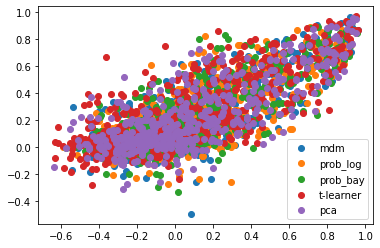

In [5]:
plot_sub_cates(sim_datasets)

In [17]:
from nudging.dataset import Pennycook1, Pennycook2, Balaban, Lieberoth, Vandenbroele, Hotard

In [18]:
all_data = {
    "penny1": Pennycook1.from_file("data"),
    "penny2": Pennycook2.from_file("data"),
    "balaban": Balaban.from_file("data"),
    "hotard": Hotard.from_file("data"),
    "lieberoth": Lieberoth.from_file("data"),
    "broele": Vandenbroele.from_file("data"),
}

In [19]:
dataset = Pennycook1.from_file("data")
for dataset_name, dataset in all_data.items():
    print(f"------ {dataset_name} ------")
    for model_name, model in models.items():
        print(model_name, compute_partition_correlation(model, dataset, KSplitPartitioner, KMeansPartitioner))

------ penny1 ------
mdm {'ksplit': 0.35351442613967576, 'kmeans': 0.80384586644083, 'all': 0.4495804094905148}
prob_log {'ksplit': 0.0065493297976704275, 'kmeans': 0.1279041067280978, 'all': 0.025372472073931476}
prob_bay {'ksplit': 0.24589734458523352, 'kmeans': 0.1489288067576807, 'all': 0.231495701829264}
t-learner {'ksplit': 0.31631366867673133, 'kmeans': 0.31554829466927253, 'all': 0.3210139722552728}
pca {'ksplit': -0.08124450591889457, 'kmeans': 0.20146036790811347, 'all': -0.02418508932043847}
------ penny2 ------
mdm {'ksplit': 0.05854547043838814, 'kmeans': 0.13190030873311204, 'all': 0.07581764334486712}
prob_log {'ksplit': 0.02922038165848663, 'kmeans': 0.11747085974102871, 'all': 0.05018603784821313}
prob_bay {'ksplit': -0.049720717417913736, 'kmeans': -0.134313739340086, 'all': -0.07252758047434478}
t-learner {'ksplit': 0.11501022392219712, 'kmeans': 0.0369104949484799, 'all': 0.10736736976503379}
pca {'ksplit': 0.1170568351767848, 'kmeans': 0.3266696246504142, 'all': 0.

/home/qubix/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/qubix/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/qubix/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/qubix/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  

mdm {'ksplit': -0.05188839326113488, 'kmeans': -0.22400953092621528, 'all': -0.12946353541064867}


/home/qubix/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/qubix/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/qubix/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/qubix/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  

prob_log {'ksplit': -0.012455605865963802, 'kmeans': 0.3655756612886253, 'all': 0.1291960488811264}


/home/qubix/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/qubix/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/qubix/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/qubix/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  

prob_bay {'ksplit': -0.028170033725612477, 'kmeans': -0.04544804881686475, 'all': -0.004133454824086613}


/home/qubix/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/qubix/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/qubix/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/qubix/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  

t-learner {'ksplit': 0.03553549370656776, 'kmeans': -0.08000271810676493, 'all': -0.014529671127814572}


/home/qubix/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/qubix/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/qubix/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/qubix/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  

pca {'ksplit': -0.03524837486393403, 'kmeans': -0.07874028921490361, 'all': -0.058488939450246774}


/home/qubix/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


In [21]:
all_data["broele"].standard_df

,age,gender,nudge,outcome,nudge_type,nudge_domain
13,20,0,0,0.0,4,3
1,21,1,0,1.0,4,3
35,20,1,0,1.0,4,3
7,20,0,0,1.0,4,3
3,21,1,0,0.0,4,3
23,21,0,0,0.0,4,3
27,20,1,0,0.0,4,3
19,20,1,0,1.0,4,3
25,20,1,0,0.0,4,3
30,20,0,1,1.0,4,3
